# CASE STUDY - evaluation metrics and business metrics


The hype surrounding the combination of good data with state-of-the art machine learning can fall short of expectations.  There are many reasons for this, far too numerous to discuss in a single course, but there are some commonalities and trends.  See the white paper [Beyond the hype: A guide to understanding and successfully implementing artificial intelligence within your business](https://www.ibm.com/downloads/cas/8ZDXNKQ4) for a deeper dive into this this .  This case study will focus on something that we are referring to as the *follow-through*.  

The basic idea of the follow-through is to tune, train and deploy your model, then once you have collected some performance data return to the familiar world of data visualization and hypothesis testing to investigate the relationship between model performance (evaluation metrics) and business metrics.

One of the reasons there has not been much focus on follow-through is that there are many projects and time is always precious.  The model is in production---okay what is the next project?  For this reason we propose readying your code for that post-performance investigation *before* the model is deployed. We are going to take it a step further and simulate performance data.  This simulation function will emulate a real-world scenario and provide a tool that you could use in your own projects to ensure that your code is ready to accommodate follow-through.

In [183]:
import os
import sys
import time
import re
import itertools
from string import punctuation, printable
import numpy as np
import pandas as pd
import spacy
from spacy.lookups import Lookups
from spacy.lemmatizer import Lemmatizer
from spacy.tokenizer import Tokenizer
import joblib
from collections import Counter
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import load_files
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import seaborn as sns
from spacy.lang.en import English

if not 'nlp' in locals():
    print("Loading English Module...")
    nlp = English()

plt.style.use('seaborn')
%matplotlib inline

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

## supress all warnings (not to be used during development)
#import warnings
#warnings.filterwarnings("ignore")

## Synopsis


AAVAIL has recently enabled comments on its streaming service.  There are a number of data science projects that have 
become a priority since.  The text will soon need to be monitored for automatic removal of inappropriate content.  Users and posts will need to be flagged for human review.  Your project will be to leverage comments for customer retention.  Following best practices you are being asked now to build your code base to ensure you are ready when the first week of comments are ready.  Management has made the specific ask that they want you to monitor the relationship between your model's performance and a customer retention business metric.  

As a first pass we are going to perform text classification for customer retention so the movie comments data set with sentiment as a target is a perfect data set to start building a code base.  We are going to give several hints about how you could improve model performance as there are many options when it come to representing your text.  Once your have iterated with respect to transforms and models you will pass the model pipeline to a special function that will simulate model performance **and**  business performance for six months.  Finally you will create a visualization to help investigate and monitor the relationship between the two.

## Outline


1. Optimize a text classification Pipeline to be deployed for use
2. Iterate on and tune the model pipeline
3. Use visualization techniques to relate the evaluation metrics to the business metrics


## Data

Here we see how to load the data.  These are the same data that were used for the topic modeling case study in the previous course. 

* [download the movie review data](http://www.nltk.org/nltk_data)
* For more examples of applications with these data see [NLTK's book chapter that uses these data](https://www.nltk.org/book/ch06.html)
* the ``target`` here is sentiment grouped into positive and negative categories.  You will use this data set to prepare a code base that will ensure you can quickly refine a customer retention model once enough video translation comments are collected by AAVAIL.

In [237]:
data_dir = os.path.join(".")
movie_reviews = load_files(os.path.join(data_dir,"movie_reviews"), shuffle=True)
X = movie_reviews.data
y = movie_reviews.target
target_names = movie_reviews.target_names

In [238]:
len(X), len(y)

(2000, 2000)

### QUESTION 1

Use print statements and visualization to summarize the data

In [185]:
print(y[:50])
print(X[0][:200])

[0 1 1 0 1 1 1 1 1 0 1 1 0 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1
 0 0 0 0 1 1 0 1 0 0 0 1 1]
b"arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr ."


In [219]:
def visualize_text_data(docs):
    doc_len = [len(doc) for doc in docs]
    fig, axs = plt.subplots(1, sharey=True, tight_layout=True)
    plt.title('Words in document')
    plt.xlabel('Documents')
    plt.ylabel('Word count')
    axs.hist(doc_len)

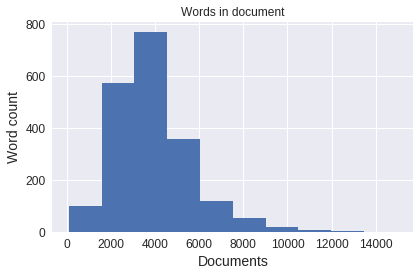

In [220]:
visualize_text_data(X)

### QUESTION 2

Process the data.  There are many options to consider when you process the tokens from a 
corpus of text.  These are some of the questions you might want to ask?

* Which stop words do I include?
* Which stemmer/lemmatizer is best?
* Which n-grams do I include?
* Do I filter based on frequency min an max?

There are many ways to process tokens (words, dates, emojis etc).  NLTK is often used to pre-process text data before the tokens are vectorized.  Generally, the tokens are modified via [stemming or lemmatization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html).  The next code block provides a lemmatization function that makes use of the library [spacy](https://spacy.io/).  You will need to install it and download the English language reference material as follows.  Stopwords are words that are very common or otherwise irrelevant we use a default list here, but it is an important part of NLP pipelines that needs to be customized for the subject area. Use the following function to process the corpus (this can take a few minutes)

```bash
~$ pip install spacy
~$ python -m spacy download en
```

Use the following function to process your data into into a clean corpus


In [188]:
STOPLIST = ENGLISH_STOP_WORDS
STOPLIST = set(list(STOPLIST) + ["foo"])

def process_docs(docs, stop_words):
    documents = []
    tokenizer = Tokenizer(nlp.vocab)
    
    for doc in docs:
        doc = ''.join(re.split('[^\w^ ]', str(doc.decode("utf-8")).lower()))
        doc = [token.lemma_ for token in tokenizer(doc) if token not in stop_words]
        documents.append(doc)
    return documents

In [189]:
docs = process_docs(X, STOPLIST)

In [227]:
docs[:][:10]

[['arnold',
  'schwarzenegger',
  'has',
  'been',
  'an',
  'icon',
  'for',
  'action',
  'enthusiasts',
  ' ',
  'since',
  'the',
  'late',
  '80s',
  ' ',
  'but',
  'lately',
  'his',
  'films',
  'have',
  'been',
  'very',
  'sloppy',
  'and',
  'the',
  'oneliners',
  'are',
  'getting',
  'worse',
  ' ',
  'its',
  'hard',
  'seeing',
  'arnold',
  'as',
  'mr',
  ' ',
  'freeze',
  'in',
  'batman',
  'and',
  'robin',
  ' ',
  'especially',
  'when',
  'he',
  'says',
  'tons',
  'of',
  'ice',
  'jokes',
  ' ',
  'but',
  'hey',
  'he',
  'got',
  '15',
  'million',
  ' ',
  'whats',
  'it',
  'matter',
  'to',
  'him',
  ' ',
  'once',
  'again',
  'arnold',
  'has',
  'signed',
  'to',
  'do',
  'another',
  'expensive',
  'blockbuster',
  ' ',
  'that',
  'cant',
  'compare',
  'with',
  'the',
  'likes',
  'of',
  'the',
  'terminator',
  'series',
  ' ',
  'true',
  'lies',
  'and',
  'even',
  'eraser',
  ' ',
  'in',
  'this',
  'so',
  'called',
  'dark',
  'thrill

### QUESTION 3

Summarize the processed corpus again (hopefully you used a function)

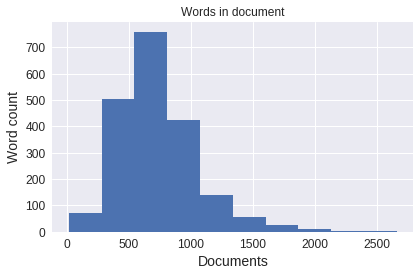

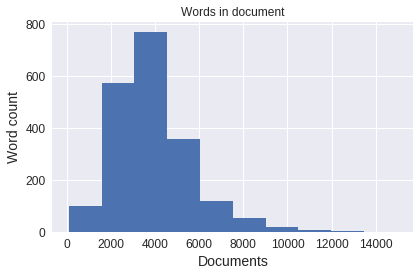

In [214]:
visualize_text_data(docs), visualize_text_data(X);

### QUESTION 4

Create a train/test split then a transformation pipeline connected to a base model.

A [bag-of-words model](https://en.wikipedia.org/wiki/Bag-of-words_model) is a representation of text.  A document or sentence is represented as numeric counts of the individual words, without considering grammar and punctuation.  Even the word order is ignored unless you expand your feature matrix with [n-grams](https://en.wikipedia.org/wiki/N-gram).

can calculate various measures to characterize the text. The most common type matrix derived from the bag-of-words
representation **term frequency (TF)**, which is the number of times a token appears in the text.  Another useful matrix
is the [term frequency-inverse document frequency (tf-idf)](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) matrix. There are variations on tf-idf and in general these derived matrices can be thought of as *transforms* that can be optimized in an iterative fashion.
   
Finish the pipeline with a naive Bayes classifier to compare transforms

Naive Bayes approaches are a commonly used base model for text
classification.

There are several types of Naive Bayes model.

* Gaussian: It is used in classification and it assumes that features follow a normal distribution.

* Multinomial: It is used for discrete counts.

* Bernoulli: The binomial model is useful if your feature vectors are binary (i.e. zeros and ones).

* Complement: CNB is an adaptation of the standard multinomial naive Bayes (MNB) algorithm that is particularly suited for imbalanced data sets

In [253]:
from sklearn.naive_bayes import ComplementNB

X_train, X_test, y_train, y_test = train_test_split([' '.join(ls) for ls in docs], y, test_size = 0.25, stratify = y)

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('comp_nb', ComplementNB())
])

param_grid1 = {
    'tfidf__max_df': [0.1, 0.3, 0.5, 0.7, 0.9], 
    'tfidf__max_features': [2000, 4000, 6000, 8000],
    'comp_nb__alpha': [0.5, 0.1, 0.01]
}

gridsearch1 = GridSearchCV(pipeline1, param_grid = param_grid1, n_jobs = -1)
gridsearch1.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                      

In [255]:
pred = gridsearch1.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.77      0.83      0.80       250
           1       0.82      0.76      0.79       250

    accuracy                           0.79       500
   macro avg       0.80      0.79      0.79       500
weighted avg       0.80      0.79      0.79       500



### QUESTION 5

See if you can beat the base model. (HINT: try using the SGDClassifier)

In [259]:
from sklearn.linear_model import SGDClassifier

pipeline2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('sgd', SGDClassifier())
])

param_grid2 = {
    'tfidf__max_df': [0.1, 0.3, 0.5, 0.7, 0.9], 
    'tfidf__max_features': [2000, 4000, 6000, 8000],
    'sgd__alpha': [0.5, 0.1, 0.01, 0.001],
    'sgd__penalty': ['l1', 'l2'],
    'sgd__loss': ['log', 'modified_huber', 'squared_hinge','perceptron']
}

gridsearch2 = GridSearchCV(pipeline2, param_grid = param_grid2, n_jobs = -1, verbose = 1)
gridsearch2.fit(X_train, y_train)

Fitting 5 folds for each of 640 candidates, totalling 3200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 3200 out of 3200 | elapsed: 13.5min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                      

In [260]:
pred = gridsearch2.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       250
           1       0.83      0.84      0.84       250

    accuracy                           0.83       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500



### QUESTION 4

Now that you have a decent classifier here is a function that will to simulate the results obtained from the deployed model over time. Simply enter the `accuracy` value. Obtained from `classification_report` on the test data.

A data frame will be returned containing.

1. Week number
2. The number of churned subscribers per 100 (expressed as a decimal)
3. The accuracy score
4. AAVAIL Website version id

Use your determined test accuracy to get back simulated data.  Then as you would with EDA
investigate the relationship between the evaluation metric and the business metric.  At a minimum the investigation should involve visualization, but hypothesis testing and/or statistical models could be useful here.

In [262]:

def simulate_production(test_accuracy, num_weeks=26):
    """
    INPUT: takes a value for test model accuracy
    OUTPUT: returns a data frame with relevant
    """
    
    if test_accuracy < 0 or test_accuracy > 1.0:
        raise Exception("test accuracy must be between 0 and 1")
    
    ## simulate test accuracy (two component gaussian)
    modes = np.random.binomial(n=1,p=0.3,size=num_weeks)
    mode1 = np.where(modes==0)[0]
    mode2 = np.where(modes==1)[0]
    projected_em = np.zeros(num_weeks)
    projected_em[mode1] = stats.norm(loc=test_accuracy,scale=0.02).rvs(mode1.size)
    projected_em[mode2] = stats.norm(loc=test_accuracy,scale=0.04).rvs(mode2.size)
    projected_em[projected_em > 0.99] = 0.99
    
    #print(projected_em)
    min_val = 0.5
    projected_bm = (1.0 - ((projected_em - min_val) / (1.0 - min_val))) * .1
    #print(projected_bm)
    
    website_effects = np.array([0.0,0.02,-0.02])
    website = np.sort(np.random.randint(0,3,num_weeks))
    
    for sv in np.unique(website):
        projected_bm[website==sv] = projected_bm[website==sv] + website_effects[sv]
    
    data = {'churn_rate':projected_bm,
            'accuracy':projected_em,
            'website':website}
    
    return(pd.DataFrame(data))

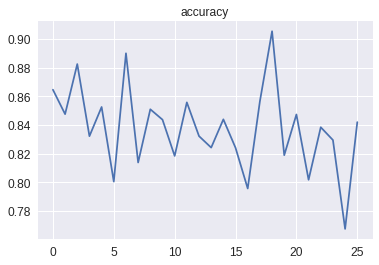

In [274]:
df = simulate_production(0.83)
plt.plot(df['accuracy'])
plt.title('accuracy');

Accuracy of the model went down ever time.

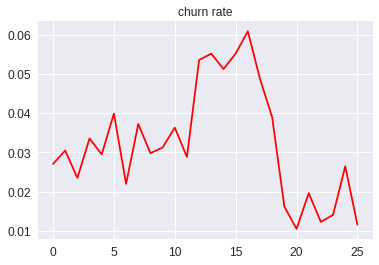

In [275]:
plt.plot(df['churn_rate'], color = 'r')
plt.title('churn rate');

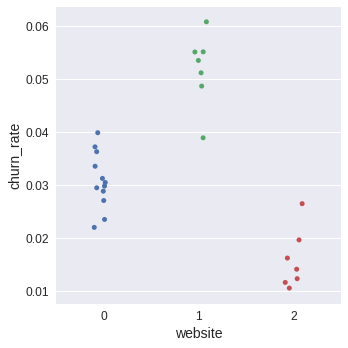

In [279]:
sns.catplot(x = 'website', y = 'churn_rate', data = df);

Version 2 of the website had the lowest churn rate, while version 1 of the website had the highest churn rate. While version 0, was in between.

Going through the exercise of creating a plot like this before the model is deployed and in production is a clear and effective way to communicate to business stakeholders exactly the type of data needed for an investigation into the business impact.